<a href="https://colab.research.google.com/github/willianncardoso/IBOVESPA/blob/RandomForestClassifier/PosFIAP_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Random Forest Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# 1. Obtenção dos Dados
# Usando 'period' para pegar os dados dos últimos 2 anos
dados = pd.read_csv('https://raw.githubusercontent.com/willianncardoso/IBOVESPA/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv')

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
1,03.07.2025,140.928,139.051,141.304,139.051,"6,08B","1,35%"
2,02.07.2025,139.051,139.586,140.049,138.384,"8,81B","-0,36%"
3,01.07.2025,139.549,138.855,139.695,138.855,"6,35B","0,50%"
4,30.06.2025,138.855,136.865,139.103,136.430,"7,68B","1,45%"


In [3]:
def converter_volume_simples(valor):
    # Deixa tudo maiúsculo, troca vírgula por ponto e remove espaços
    valor_str = str(valor).upper().replace(',', '.').strip()

    if 'B' in valor_str:
        return int(float(valor_str.replace('B', '')) * 1_000_000_000)
    elif 'M' in valor_str:
        return int(float(valor_str.replace('M', '')) * 1_000_000)
    else:
        # Se não tiver letra, apenas converte para número
        return int(float(valor_str))

# 2. Aplique a função diretamente na coluna 'Volume'
dados['Vol.'] = dados['Vol.'].apply(converter_volume_simples)

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      502 non-null    object 
 1   Último    502 non-null    float64
 2   Abertura  502 non-null    float64
 3   Máxima    502 non-null    float64
 4   Mínima    502 non-null    float64
 5   Vol.      502 non-null    int64  
 6   Var%      502 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 27.6+ KB


In [4]:
dados['Var%'] = pd.to_numeric(dados['Var%'].str.replace('%', '').str.replace(',', '.')) / 100

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      502 non-null    object 
 1   Último    502 non-null    float64
 2   Abertura  502 non-null    float64
 3   Máxima    502 non-null    float64
 4   Mínima    502 non-null    float64
 5   Vol.      502 non-null    int64  
 6   Var%      502 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 27.6+ KB


In [5]:
# 2. Engenharia de Atributos para Classificação

# Criando a variável-alvo (Target)
# 1 se o preço de fechamento de amanhã for MAIOR que o de hoje, 0 caso contrário
dados['Target'] = (dados['Último'].shift(-1) > dados['Último']).astype(int)

# Remover a última linha que terá um 'Target' NaN
dados.dropna(inplace=True)

In [6]:
# 3. Criação das Variáveis Preditivas (Features)

# Lags (preços dos dias anteriores)
for i in range(1, 6):
    dados[f'Lag_{i}'] = dados['Último'].shift(i)

# Médias Móveis
dados['SMA_10'] = dados['Último'].rolling(window=10).mean()
dados['SMA_30'] = dados['Último'].rolling(window=30).mean()

# Volatilidade (desvio padrão dos retornos em uma janela)
# dados['Volatility_10'] = dados['Daily_Return'].rolling(window=10).std()

# Remover linhas com NaN gerados pelas features
dados.dropna(inplace=True)

print("\n--- Dados Finais com Features ---")
dados


--- Dados Finais com Features ---


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Target,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,SMA_10,SMA_30
29,23.05.2025,137.824,137.273,137.824,134.997,10680000000,0.0040,0,138.136,139.541,138.888,138.534,137.027,137.7521,137.831267
30,22.05.2025,137.273,137.881,138.837,137.088,13220000000,-0.0044,1,137.824,138.136,139.541,138.888,138.534,137.8558,137.698233
31,21.05.2025,137.881,140.109,140.109,137.538,10150000000,-0.0159,1,137.273,137.824,138.136,139.541,138.888,137.9437,137.596667
32,20.05.2025,140.110,139.636,140.244,138.966,9650000000,0.0034,0,137.881,137.273,137.824,138.136,139.541,138.2001,137.631967
33,19.05.2025,139.636,139.186,140.203,138.587,9590000000,0.0032,0,140.110,137.881,137.273,137.824,138.136,138.4850,137.634867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,06.07.2023,117.426,119.548,119.548,117.096,11030000,-0.0178,1,118.898,117.942,117.556,117.666,119.264,118.0075,119.015767
498,05.07.2023,119.549,119.072,120.200,118.688,10960000,0.0040,0,117.426,118.898,117.942,117.556,117.666,118.2072,119.147667
499,04.07.2023,119.076,119.673,119.678,118.830,6560000,-0.0050,1,119.549,117.426,118.898,117.942,117.556,118.3307,119.244500
500,03.07.2023,119.673,118.092,119.877,118.092,8910000,0.0134,0,119.076,119.549,117.426,118.898,117.942,118.4761,119.339933


In [7]:
# 4. Preparação para o Modelo
features = [col for col in dados.columns if col not in ['Data','Target']]
X = dados[features]
y = dados['Target']

# Divisão cronológica dos dados (80% treino, 20% teste)
tamanho_treino = int(len(dados) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"\nTamanho do conjunto de Treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de Teste: {len(X_teste)} amostras")


Tamanho do conjunto de Treino: 378 amostras
Tamanho do conjunto de Teste: 95 amostras


In [14]:
# Verificar onde há vazamento de dados
print("--- Verificando as colunas em X antes do treino ---")
print(X_treino.columns.tolist())


--- Verificando as colunas em X antes do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'SMA_10', 'SMA_30']


In [15]:
# 5. Treinamento do Modelo
# RandomForestClassifier para problemas de classificação
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_treino, y_treino)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [16]:
# Verificar onde há vazamento de dados
print("\n--- Verificando as colunas em X depois do treino ---")
print(X_teste.columns.tolist())


--- Verificando as colunas em X depois do treino ---
['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'SMA_10', 'SMA_30']



--- Resultados da Avaliação ---
Acurácia do Modelo: 98.95%

Relatório de Classificação:
                  precision    recall  f1-score   support

Caiu/Manteve (0)       1.00      0.98      0.99        43
       Subiu (1)       0.98      1.00      0.99        52

        accuracy                           0.99        95
       macro avg       0.99      0.99      0.99        95
    weighted avg       0.99      0.99      0.99        95


Matriz de Confusão:


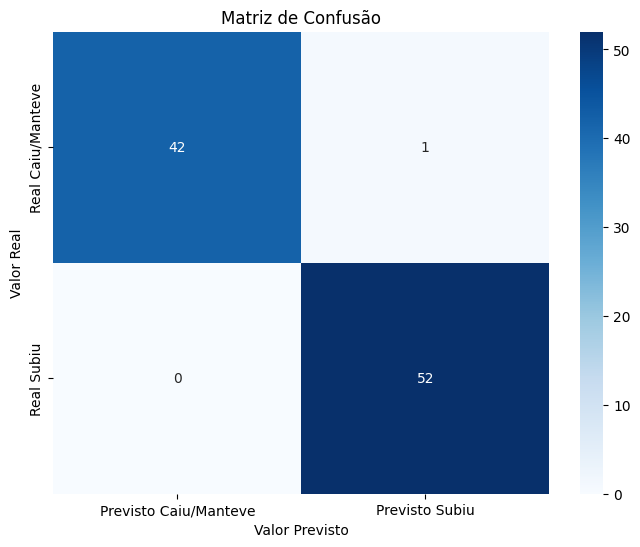

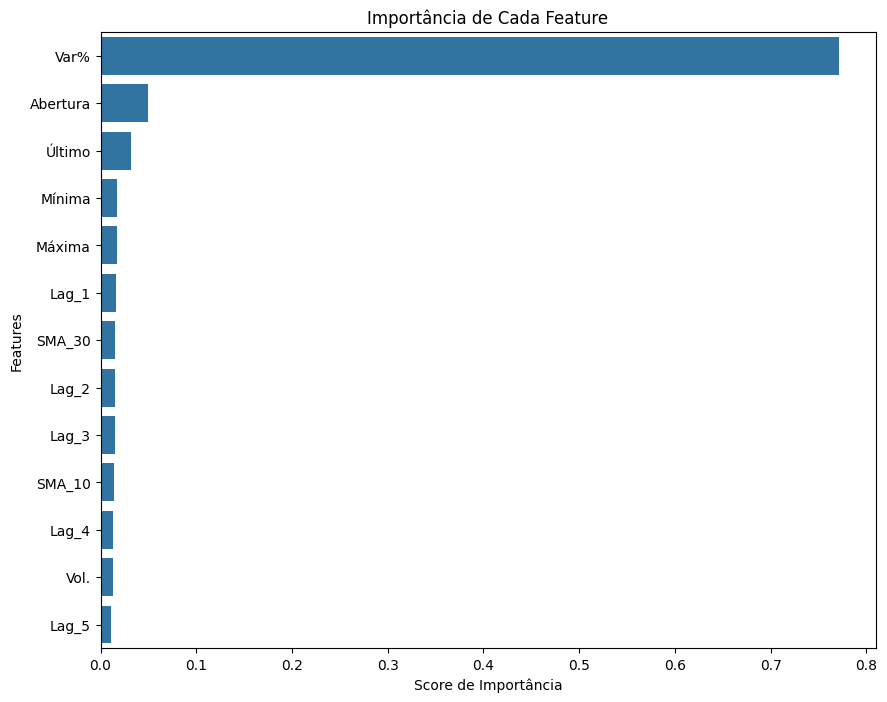

In [9]:
# 6. Avaliação do Desempenho
previsoes = modelo.predict(X_teste)

# Calcular a acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"\n--- Resultados da Avaliação ---")
print(f"Acurácia do Modelo: {acuracia:.2%}")

# Exibir o Relatório de Classificação
print("\nRelatório de Classificação:")
# target_names mapeia os valores 0 e 1 para rótulos mais claros
print(classification_report(y_teste, previsoes, target_names=['Caiu/Manteve (0)', 'Subiu (1)']))

# Exibir a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Caiu/Manteve', 'Previsto Subiu'],
            yticklabels=['Real Caiu/Manteve', 'Real Subiu'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# Importância das Features
# Ver quais features o modelo considerou mais importantes para a decisão
importancias = pd.Series(modelo.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=importancias, y=importancias.index)
plt.title('Importância de Cada Feature')
plt.xlabel('Score de Importância')
plt.ylabel('Features')
plt.show()

In [10]:
dados

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Target,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,SMA_10,SMA_30
29,23.05.2025,137.824,137.273,137.824,134.997,10680000000,0.0040,0,138.136,139.541,138.888,138.534,137.027,137.7521,137.831267
30,22.05.2025,137.273,137.881,138.837,137.088,13220000000,-0.0044,1,137.824,138.136,139.541,138.888,138.534,137.8558,137.698233
31,21.05.2025,137.881,140.109,140.109,137.538,10150000000,-0.0159,1,137.273,137.824,138.136,139.541,138.888,137.9437,137.596667
32,20.05.2025,140.110,139.636,140.244,138.966,9650000000,0.0034,0,137.881,137.273,137.824,138.136,139.541,138.2001,137.631967
33,19.05.2025,139.636,139.186,140.203,138.587,9590000000,0.0032,0,140.110,137.881,137.273,137.824,138.136,138.4850,137.634867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,06.07.2023,117.426,119.548,119.548,117.096,11030000,-0.0178,1,118.898,117.942,117.556,117.666,119.264,118.0075,119.015767
498,05.07.2023,119.549,119.072,120.200,118.688,10960000,0.0040,0,117.426,118.898,117.942,117.556,117.666,118.2072,119.147667
499,04.07.2023,119.076,119.673,119.678,118.830,6560000,-0.0050,1,119.549,117.426,118.898,117.942,117.556,118.3307,119.244500
500,03.07.2023,119.673,118.092,119.877,118.092,8910000,0.0134,0,119.076,119.549,117.426,118.898,117.942,118.4761,119.339933


In [11]:
!pip install pandas_ta
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=c5445048773b8c8c95008bb553f1c73f6c5f8bc889cb17e54e4b768017a3e378
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [12]:
# IMportar biblioteca com indicadores
import pandas_ta as ta
import yfinance as yf


# Adicionando um conjunto de indicadores técnicos populares com uma única linha de código
dados.ta.strategy("common", append=True)

# # Vamos adicionar mais alguns úteis individualmente
# dados.ta.macd(append=True) # Moving Average Convergence Divergence
# dados.ta.rsi(append=True)  # Relative Strength Index

# # Adicionar o contexto do mercado geral (Ibovespa)
# ibov = yf.download('^BVSP', period='2y', auto_adjust=True)
# # Calcular o retorno diário do Ibovespa e adicionar aos nossos dados
# dados['IBOV_Return'] = ibov['Close'].pct_change()

# # Remover as linhas com valores NaN que foram geradas
# dados.dropna(inplace=True)

# print("\n--- Colunas disponíveis após adicionar indicadores ---")
# print(dados.columns)

ImportError: cannot import name 'NaN' from 'numpy' (/usr/local/lib/python3.11/dist-packages/numpy/__init__.py)

In [ ]:
dados.head()